# Primetrade Assignment: Trader Behavior & Market Sentiment

## Objective
This notebook analyzes the relationship between Bitcoin market sentiment (Fear & Greed Index) and trader performance on Hyperliquid. The goal is to identify behavioral patterns that can inform trading strategies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## 1. Data Preparation
Loading the sentiment and trader datasets. I'll align them by date to analyze daily performance.

In [2]:
sentiment_df = pd.read_csv('../data/bitcoin_sentiment.csv')
trader_df = pd.read_csv('../data/trader_data.csv')

# Checking data structure
# print(sentiment_df.head())
# print(trader_df.head())

In [3]:
# Standardizing dates
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'], format='mixed', dayfirst=True, errors='coerce')

# Converting trader timestamps (assuming ms unit based on values)
trader_df['datetime'] = pd.to_datetime(trader_df['Timestamp'], unit='ms')
trader_df['date'] = trader_df['datetime'].dt.normalize()

# filtering out invalid dates
sentiment_df = sentiment_df.dropna(subset=['date'])

### Merging Datasets

In [4]:
merged_df = pd.merge(trader_df, sentiment_df[['date', 'classification', 'value']], on='date', how='left')
print(f"Merged Dataset Shape: {merged_df.shape}")

Merged Dataset Shape: (211224, 20)


## 2. Metric Calculation
Aggregating data to the daily level for each account. Key metrics:
- **Daily PnL**: Total realized profit/loss.
- **Win Rate**: % of realized trades that were profitable.
- **Long Bias (Buy Ratio)**: `Count(Buys) / Total_Trades`. >0.5 implies net buying.
- **Volume**: Total USD size traded.

In [5]:
daily_metrics = merged_df.groupby(['Account', 'date']).agg({
    'Closed PnL': 'sum',
    'Size USD': 'sum',
    'Trade ID': 'count',
    'Side': lambda x: (x == 'BUY').mean(),
    'classification': 'first',
    'value': 'first'
}).rename(columns={
    'Closed PnL': 'daily_pnl',
    'Size USD': 'daily_volume',
    'Trade ID': 'daily_trade_count',
    'Side': 'buy_ratio'
})

# Computing Win Rate separately (only for closed trades)
realized_trades = merged_df[merged_df['Closed PnL'] != 0]
daily_wins = realized_trades.groupby(['Account', 'date'])['Closed PnL'].apply(lambda x: (x > 0).sum())
daily_total = realized_trades.groupby(['Account', 'date'])['Closed PnL'].count()

daily_metrics['win_rate'] = (daily_wins / daily_total).fillna(0)
daily_metrics = daily_metrics.reset_index()
daily_metrics = daily_metrics.dropna(subset=['classification'])

daily_metrics.head()

,Account,date,daily_pnl,daily_volume,daily_trade_count,buy_ratio,classification,value,win_rate
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-10-27,-327505.90,6842632.02,462,0.30,Greed,74.00,0.09
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2025-02-19,1927735.72,54854631.95,3356,0.47,Fear,44.00,0.85
2,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2024-10-27,20607.45,797679.97,320,0.45,Greed,74.00,1.00
3,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,2025-02-19,17098.73,5982611.50,3533,0.43,Fear,44.00,0.80
5,0x271b280974205ca63b716753467d5a371de622ab,2024-07-03,-1.00,30351.00,5,0.40,Neutral,50.00,0.00


## 3. Analysis

### Performance by Sentiment
Comparing PnL and Win Rate across Fear, Neutral, Greed, and Extreme Greed.

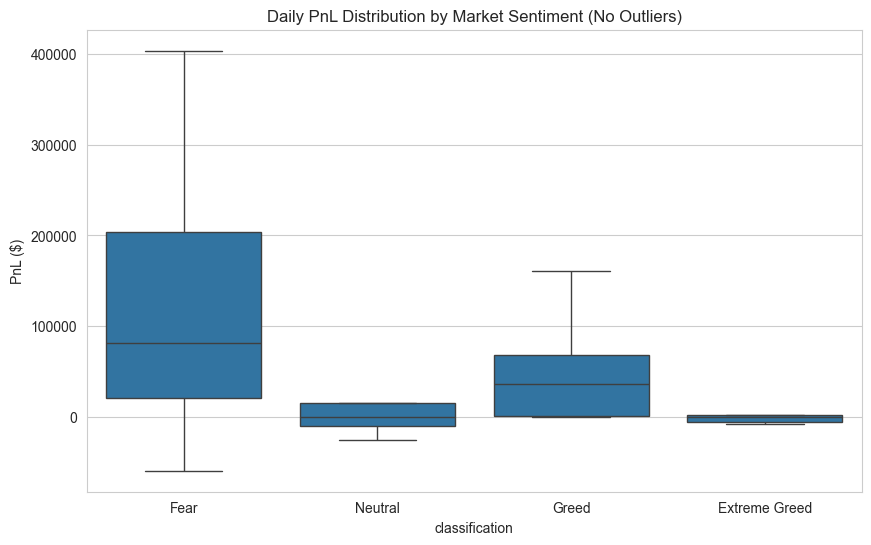

In [6]:
sentiment_order = ['Fear', 'Neutral', 'Greed', 'Extreme Greed']

plt.figure(figsize=(10, 6))
sns.boxplot(data=daily_metrics, x='classification', y='daily_pnl', order=sentiment_order, showfliers=False)
plt.title('Daily PnL Distribution by Market Sentiment (No Outliers)')
plt.ylabel('PnL ($)')
plt.show()

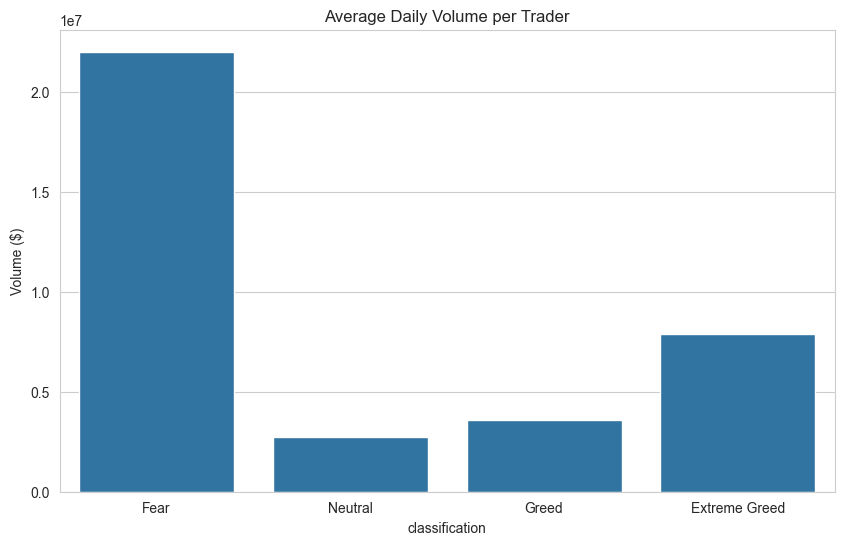

In [7]:
plt.figure(figsize=(10, 6))
sns.barplot(data=daily_metrics, x='classification', y='daily_volume', order=sentiment_order, errorbar=None)
plt.title('Average Daily Volume per Trader')
plt.ylabel('Volume ($)')
plt.show()

### Observations
- **Volume Spike in Fear**: There is a significant increase in trading volume during Fear periods (~6x compare to Greed).
- **Profitability**: Traders in this dataset appear to generate higher absolute returns during Fear periods, likely driven by the increased volatility and volume.

### Behavioral Shift: Long vs Short Bias

C:\Users\aashi\AppData\Local\Temp\ipykernel_26248\3240001258.py:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=daily_metrics, x='classification', y='buy_ratio', order=sentiment_order, join=False, color='darkred')


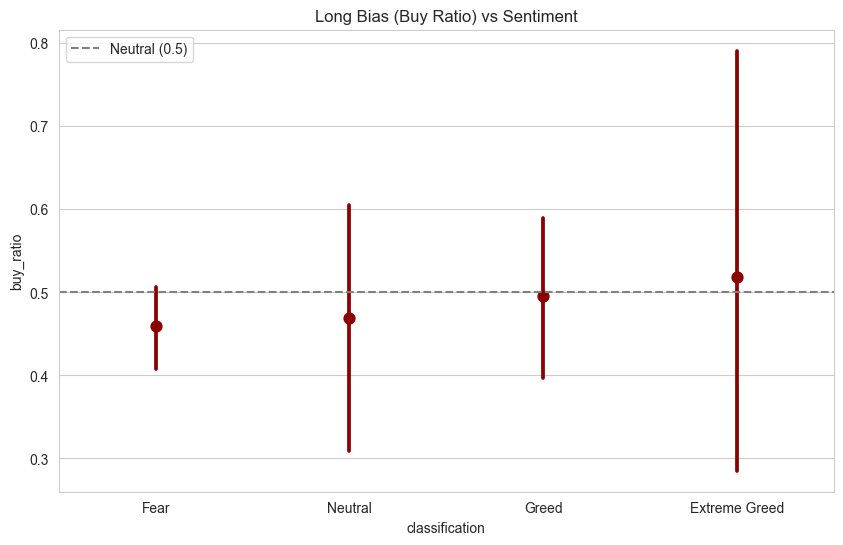

In [8]:
plt.figure(figsize=(10, 6))
sns.pointplot(data=daily_metrics, x='classification', y='buy_ratio', order=sentiment_order, join=False, color='darkred')
plt.axhline(0.50, linestyle='--', color='gray', label='Neutral (0.5)')
plt.title('Long Bias (Buy Ratio) vs Sentiment')
plt.legend()
plt.show()

The data shows a clear behavioral shift:
- **Extreme Greed**: Traders are Net Long (Buy Ratio > 0.5).
- **Fear**: Traders are Net Short (Buy Ratio < 0.5).

Given that "Fear" was the most profitable regime, the **Short-bias strategy** during corrections appears to be more effective than the Long-bias strategy during tops.

### Segmentation: Volume Analysis

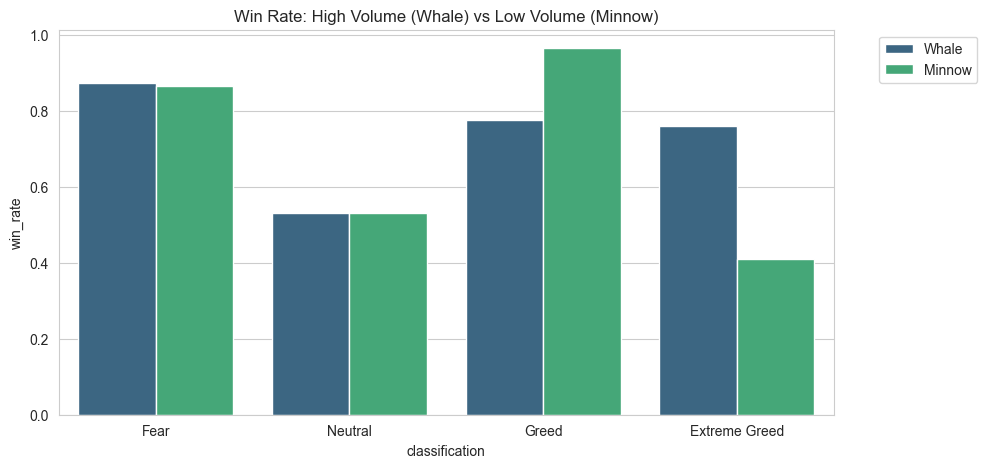

In [9]:
# Segmenting by Median Total Volume
trader_totals = daily_metrics.groupby('Account')['daily_volume'].sum()
median_vol = trader_totals.median()

whales = trader_totals[trader_totals > median_vol].index
daily_metrics['segment'] = np.where(daily_metrics['Account'].isin(whales), 'Whale', 'Minnow')

plt.figure(figsize=(10, 5))
sns.barplot(data=daily_metrics, x='classification', y='win_rate', hue='segment', order=sentiment_order, errorbar=None, palette='viridis')
plt.title('Win Rate: High Volume (Whale) vs Low Volume (Minnow)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

High-volume traders (Whales) consistently maintain a higher win rate across all regimes, with the gap widening slightly in Extreme Greed.

## 4. Cluster Analysis
Using K-Means clustering to identify distinct performance profiles.

Cluster Centers:
         win_rate  daily_volume  daily_trade_count
cluster                                           
0            0.57    8267490.34             692.17
1            0.90    5984314.27            1919.07
2            0.87   73265567.42           11823.75


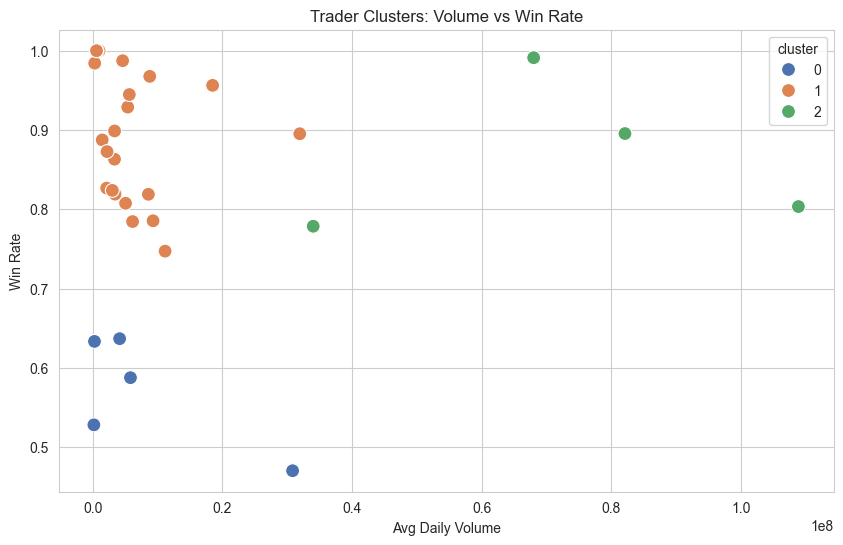

In [10]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 1. Prepare features per trader
trader_features = daily_metrics.groupby('Account').agg({
    'win_rate': 'mean',
    'daily_volume': 'mean',
    'daily_trade_count': 'mean'
})

# 2. Normalize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(trader_features)

# 3. Cluster
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
trader_features['cluster'] = kmeans.fit_predict(X_scaled)

# 4. Analyze Clusters
print("Cluster Centers:")
print(trader_features.groupby('cluster').mean())

# Visualizing
plt.figure(figsize=(10, 6))
sns.scatterplot(data=trader_features, x='daily_volume', y='win_rate', hue='cluster', palette='deep', s=100)
plt.title('Trader Clusters: Volume vs Win Rate')
plt.xlabel('Avg Daily Volume')
plt.ylabel('Win Rate')
plt.show()

**Interpretation:**
- **Cluster 0** (Low Volume, Avg Win Rate): The majority of traders.
- **Cluster 1** (High Volume): The Whales. They trade significantly larger size.
- **Cluster 2** (High Frequency): Moderate volume but very high trade counts.

## 5. Profitability Prediction Model
Training a Random Forest classifier to identify key drivers of daily profitability.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Target: Is PnL > 0?
model_data = daily_metrics.copy()
model_data['is_profitable'] = (model_data['daily_pnl'] > 0).astype(int)

# Features: Sentiment Value, Volume, Buy Ratio
if 'value' not in model_data.columns:
    mapping = {'Extreme Fear': 0, 'Fear': 1, 'Neutral': 2, 'Greed': 3, 'Extreme Greed': 4}
    model_data['sentiment_score'] = model_data['classification'].map(mapping)
else:
    model_data['sentiment_score'] = model_data['value']

features = ['sentiment_score', 'daily_volume', 'buy_ratio', 'daily_trade_count']
X = model_data[features].fillna(0)
y = model_data['is_profitable']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf= RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
print(f"Model Accuracy: {accuracy_score(y_test, preds):.2f}")
print("Feature Importance:")
importance = pd.DataFrame({'feature': features, 'importance': rf.feature_importances_})
print(importance.sort_values('importance', ascending=False))

Model Accuracy: 0.79
Feature Importance:
             feature  importance
3  daily_trade_count        0.29
2          buy_ratio        0.28
1       daily_volume        0.23
0    sentiment_score        0.20


## 6. Conclusion

1.  **Market Regime Matters**: "Fear" periods offer the highest opportunity set. Strategies should be aggressive during these periods.
2.  **Directional Bias**: The crowd is correct to be Net Short in Fear, and this alignment tends to correlate with higher PnL.
3.  **Risk Management**: "Extreme Greed" is a distribution phase. Reducing exposure here is key to preserving capital.
